In [2]:
import numpy as np
from scipy.optimize import curve_fit
from utils import process_csv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
confidence_level = 0.90
folder_path = '/home/u1604520/results/cas/'

In [4]:
B = 200
c = 100
R = 100

In [5]:
def reg_func(theta,x):
    return theta[0] + theta[1]*x + theta[2]*x**2

def nonlinear_model(x, a, b, c):
    return a + b*x + c*x**2

Fit model with generated X to get pseudo-ground-truth

In [6]:
num_params = 3
num_methods = 1
mses = np.zeros(R)
stds = np.zeros(R)
counts = np.zeros(num_params)
coverage_probabilities = np.zeros(num_params)
counts = np.zeros(num_params)
seed = 12
data, x = process_csv('CASschools.csv')
initial_guess = np.random.uniform(low=-100, high=100, size=(3,)) #[0, 4]  # Initial parameter guess
theta_star, _ = curve_fit(nonlinear_model, x, data[:,1], p0=initial_guess)
print(theta_star)

for r in range(R):
    seed += 1
    boot_sample = np.loadtxt(folder_path+f'sample_c{c}_B{B}_seed{seed}.txt')
    mean_boot_sample = boot_sample.mean(axis=0)

    predictions_npl = reg_func(mean_boot_sample, x)
    mses[r] = np.mean(np.asarray((predictions_npl-data[:,1])**2/np.mean(data[:,1])))
    stds[r] = np.std(np.asarray((predictions_npl-data[:,1])**2/np.mean(data[:,1]))) #


    for i in range(num_params):
        count = 0
        lower_bound = np.percentile(boot_sample[:, i], (1 - confidence_level) / 2 * 100)
        upper_bound = np.percentile(boot_sample[:, i], (1 + confidence_level) / 2 * 100)
        if lower_bound <= theta_star[i] <= upper_bound:
            count += 1
        counts[i] += count
            
# Calculate the coverage probability
coverage_probabilities = counts / R
        
print(f"Coverage Probability for theta_1: {coverage_probabilities[0] * 100}%")
print(f"Coverage Probability for theta_2: {coverage_probabilities[1] * 100}%")
print(f"Coverage Probability for theta_3: {coverage_probabilities[2] * 100}%")
print(f"Mean Squared error for Robust-MEM: {mses.mean()}")
#print(f"Mean Squared error for Least Squares: {mses[1]}")
print(f"Std - Mean Squared error for Robust-MEM: {stds.mean()}")
#     print(f"Std - Mean Squared error for Least Squares: {stds_mses_over_runs[j, 1, :]}")
        

[ 6.07009435e+02  3.88701173e+00 -4.32486112e-02]
Coverage Probability for theta_1: 100.0%
Coverage Probability for theta_2: 100.0%
Coverage Probability for theta_3: 100.0%
Mean Squared error for Robust-MEM: 0.2504727678835478
Std - Mean Squared error for Robust-MEM: 0.3696673716015335


Plots

In [6]:
def lighten_color(color, amount=0.5):
    """
    From: https://stackoverflow.com/questions/37765197/darken-or-lighten-a-color-in-matplotlib
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

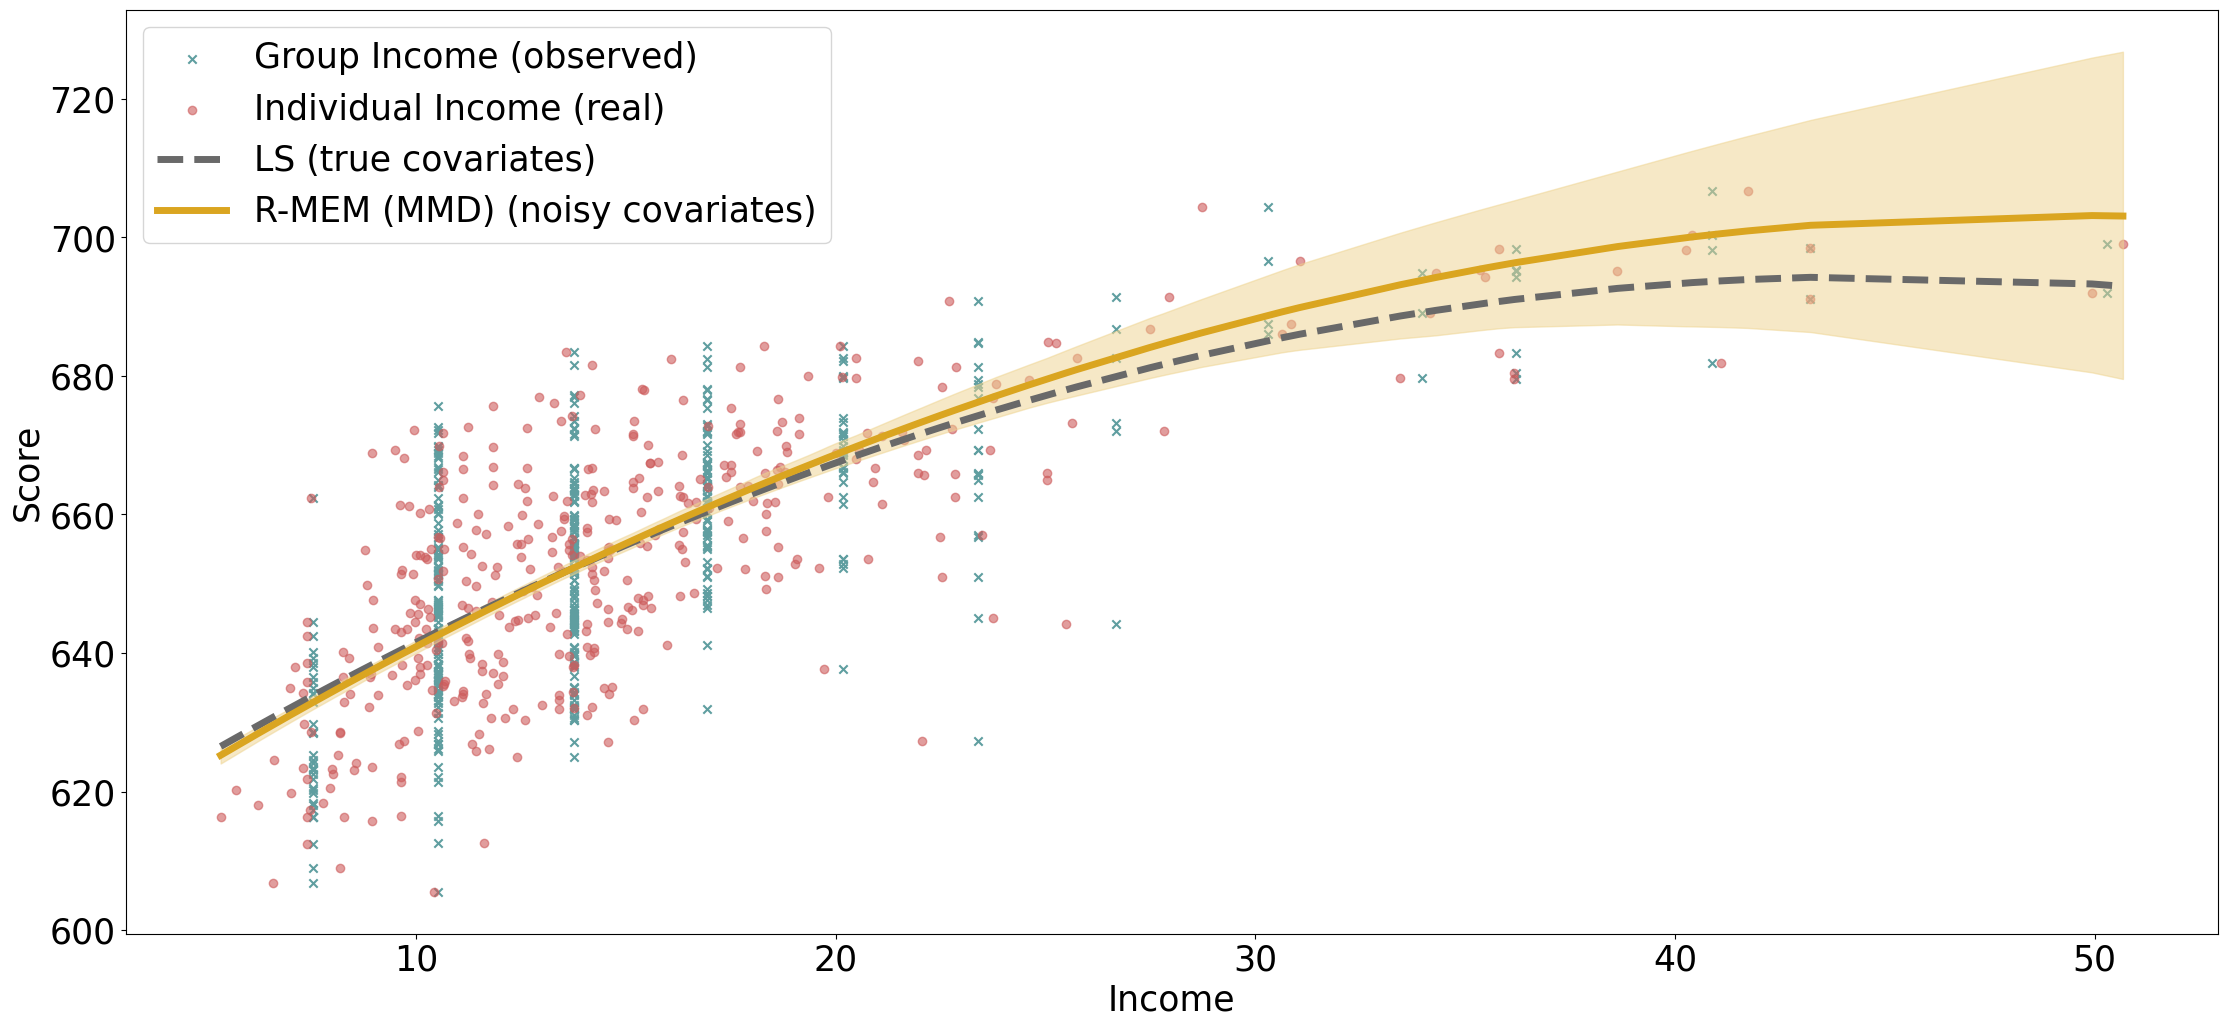

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(27,12))
seed = 13
credible_interval = 0.9

data, x = process_csv('CASschools.csv')
boot_sample = np.loadtxt(folder_path+f'sample_c{c}_B{B}_seed{seed}.txt')
mean_boot_sample = boot_sample.mean(axis=0)
        
initial_guess = np.random.uniform(low=-100, high=100, size=(3,)) #[0, 4]  # Initial parameter guess
ls_estimator, _ = curve_fit(nonlinear_model, x, data[:,1], p0=initial_guess)
  
idx_arr = np.argsort(x)
x_sorted = x[idx_arr]

Y = reg_func(mean_boot_sample, x_sorted)
Y_ls = reg_func(ls_estimator, x_sorted)

# res_npl = np.abs(Y - data[:,1][idx_arr])
# res_ls = np.abs(Y_ls - data[:,1][idx_arr])

regs = np.zeros((B, len(x)))
for i in range(B):
    regs[i,:] = reg_func(np.asarray(boot_sample[i,:]), x_sorted)
        
lower_bounds = np.percentile(regs, (1 - credible_interval) / 2 * 100, axis=0)
upper_bounds = np.percentile(regs, (1 + credible_interval) / 2 * 100, axis=0)
mean_reg = np.mean(regs, axis=0)

ax.scatter(data[:,0],data[:,1], marker="x", label='Group Income (observed)', color='cadetblue', alpha=1)
ax.scatter(x, data[:,1], marker = "o", label='Individual Income (real)', color=lighten_color('indianred',amount=1), alpha=0.6)

ax.plot(x_sorted, Y_ls, '--', label='LS (true covariates)', color='dimgrey', lw=5)
# ax.fill_between(x_sorted, Y_ls - res_ls, Y_ls + res_ls, color=lighten_color('#4682B4'), alpha=0.5)

ax.plot(x_sorted, mean_reg, label='R-MEM (MMD) (noisy covariates)', color='goldenrod',lw=5)
ax.fill_between(x_sorted, lower_bounds, upper_bounds, color=lighten_color('goldenrod'), alpha=0.5)
ax.yaxis.grid(False)
ax.xaxis.grid(False)
ax.patch.set_facecolor('white')

ax.set_xlabel('Income',fontsize=25)
ax.set_ylabel('Score',fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=25)
ax.tick_params(axis='both', which='minor', labelsize=25)

ax.legend(fontsize=25)

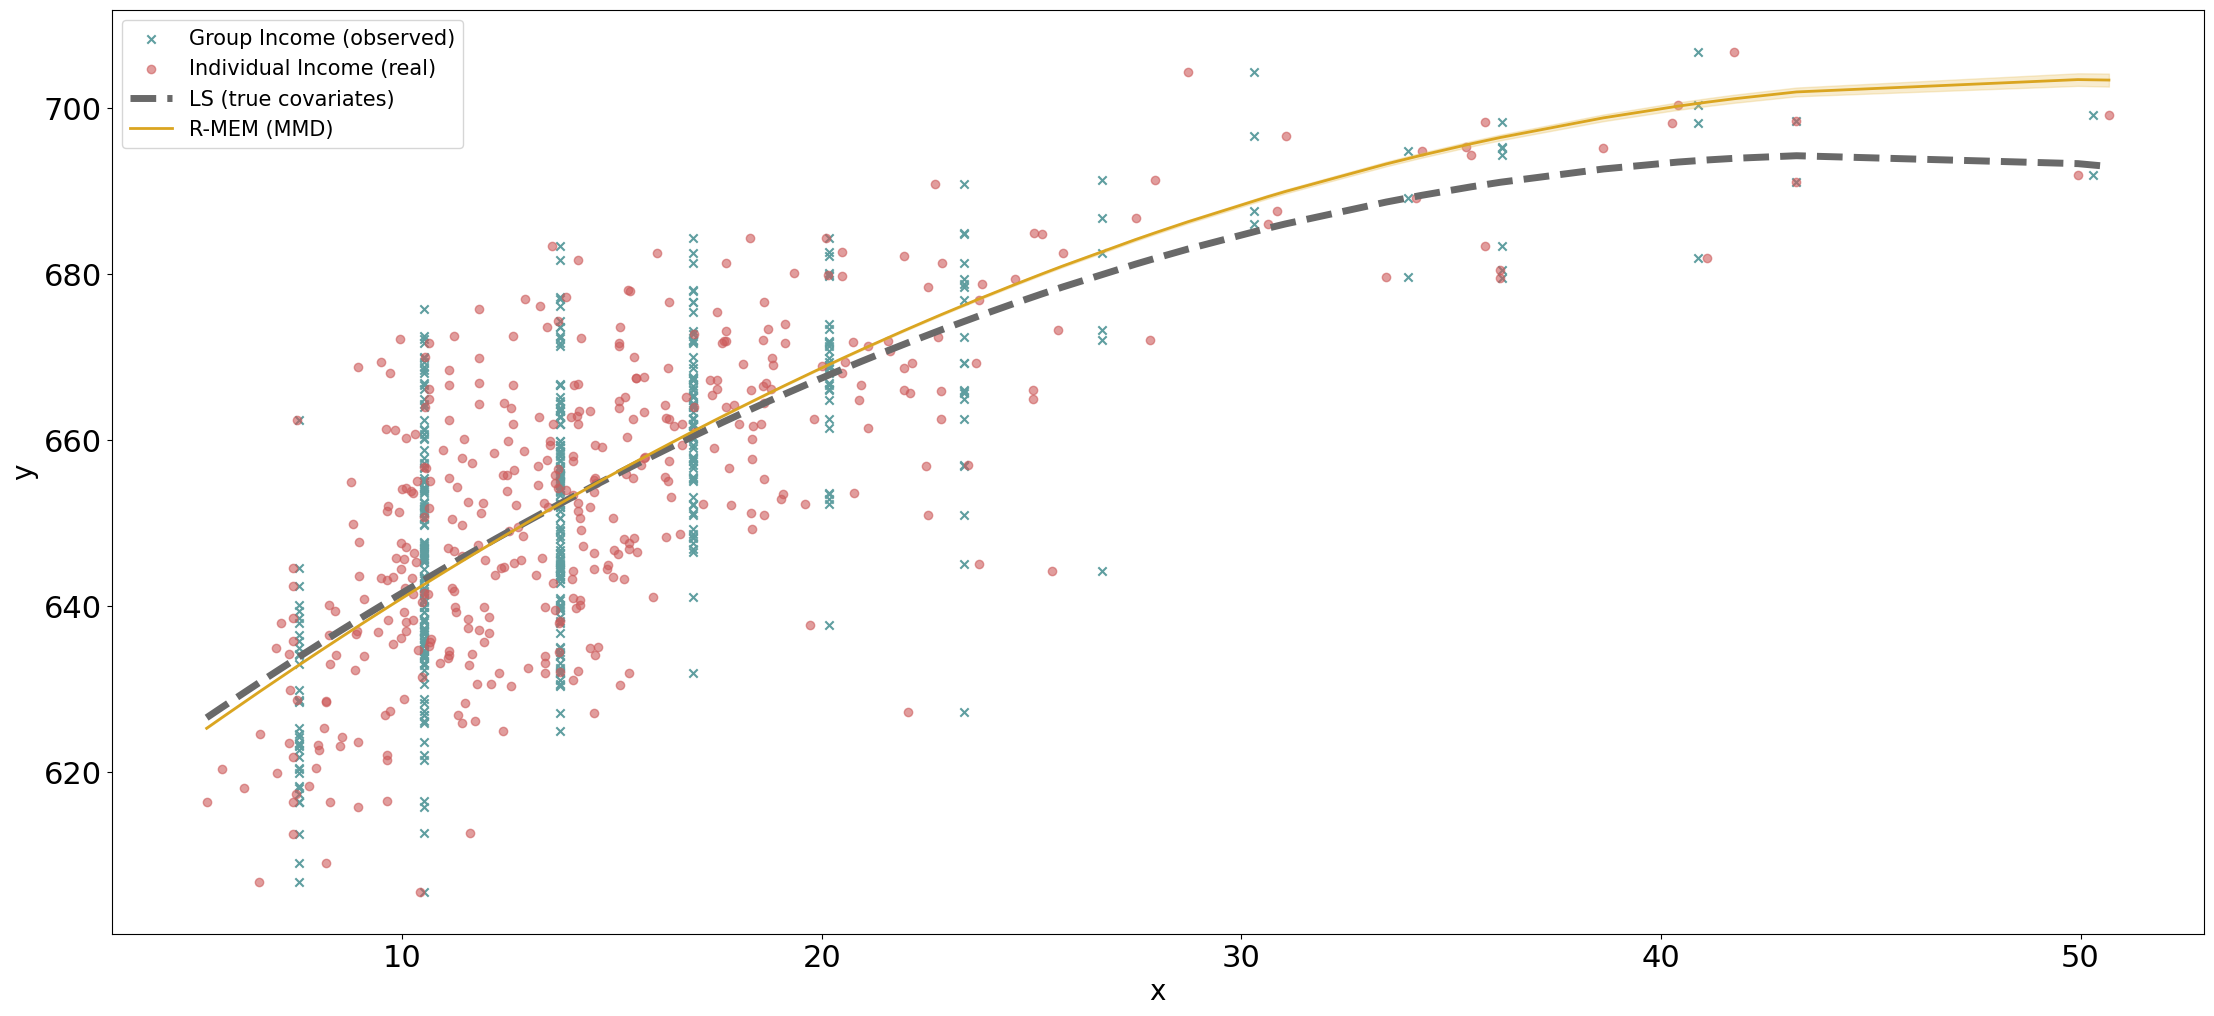

In [8]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(27,12))
seed = 12
credible_interval = 0.85

data, x = process_csv('CASschools.csv')
n = len(x)
regs = np.zeros((R, n))
lower_bounds = np.zeros(n) 
upper_bounds = np.zeros(n)
std_error = np.zeros(n)
means = np.zeros(n)
        
initial_guess = np.random.uniform(low=-100, high=100, size=(3,)) #[0, 4]  # Initial parameter guess
ls_estimator, _ = curve_fit(nonlinear_model, x, data[:,1], p0=initial_guess)
  
idx_arr = np.argsort(x)
x_sorted = x[idx_arr]

Y = reg_func(mean_boot_sample, x_sorted)
Y_ls = reg_func(ls_estimator, x_sorted)

regs = np.zeros((R, n))
lower_bounds = np.zeros((n)) 
upper_bounds = np.zeros((n))
means = np.zeros((n))
thetas_over_run = np.zeros((len(theta_star), R))
for r in range(R):
    seed += 1
    boot_sample = np.loadtxt(folder_path+f'sample_c{c}_B{B}_seed{seed}.txt')
    mean_boot_sample = boot_sample.mean(axis=0)
    initial_guess = np.random.uniform(low=-1, high=4, size=(2,)) #[0, 4]  # Initial parameter guess
    thetas_over_run[:, r] = mean_boot_sample
    regs[r, :] = reg_func(mean_boot_sample, x_sorted)
 

# lower_bounds[0, :] = reg_func(thetas_over_run.mean(axis=1) - thetas_over_run.std(axis=1), x_sorted)
# upper_bounds[0, :] = reg_func(thetas_over_run.mean(axis=1) + thetas_over_run.std(axis=1), x_sorted)
means = reg_func(thetas_over_run.mean(axis=1), x_sorted)
residuals = data[:,1] - regs
std_error = np.std(residuals, axis=0)


    
ax.scatter(data[:,0],data[:,1], marker="x", label='Group Income (observed)', color='cadetblue', alpha=1)
ax.scatter(x, data[:,1], marker = "o", label='Individual Income (real)', color=lighten_color('indianred',amount=1), alpha=0.6)

ax.plot(x_sorted, Y_ls, '--', label='LS (true covariates)', color='dimgrey', lw=5)
    
ax.plot(x_sorted, means, linestyle='solid', label='R-MEM (MMD)', color='goldenrod',lw=2)
ax.fill_between(x_sorted, means - std_error, means + std_error, color=lighten_color('goldenrod', 0.7), alpha=0.3)
    
   
ax.yaxis.grid(False)
ax.xaxis.grid(False)
ax.patch.set_facecolor('white')
   
ax.set_xlabel('x',fontsize=20)
ax.set_ylabel('y',fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=22)
ax.tick_params(axis='both', which='minor', labelsize=22)
    
ax.legend(fontsize=15)

In [9]:
min(upper_bounds-lower_bounds), max(upper_bounds-lower_bounds)

(0.4667496242376501, 62.175214750545706)